In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os
import gdown
import zipfile
from tqdm.auto import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
os.makedirs("celeba_gan", exist_ok=True)

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with zipfile.ZipFile(output, "r") as zipobj:
    zipobj.extractall("celeba_gan")

Dataset size: 202599


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


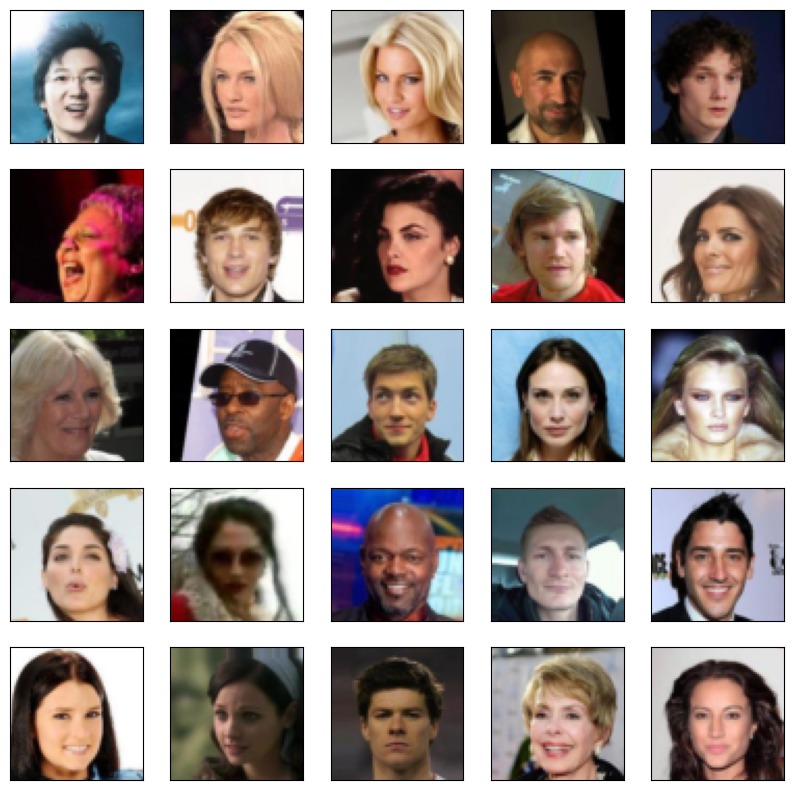

In [ ]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1]
])

dataset = ImageFolder(root="celeba_gan", transform=transform)

dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

print(f"Dataset size: {len(dataset)}")

imgs, _ = next(iter(dataloader))
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = (imgs[i].permute(1, 2, 0).numpy() + 1) / 2.0  # [-1,1] -> [0,1]
    plt.imshow(img)
plt.show()

In [ ]:
latent_dim = 128

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.main = nn.Sequential(
            # Input: latent_dim -> 8x8x256
            nn.Linear(latent_dim, 8 * 8 * 256),
            nn.Unflatten(1, (256, 8, 8)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            # 16x16 -> 32x32
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            # 32x32 -> 64x64
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # Output: 64x64x3
            nn.Conv2d(64, 3, 5, padding=2),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # Input: 64x64x3
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            # 32x32
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            # 16x16
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            # 8x8
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            # 4x4 -> flatten -> 1
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
        )

    def forward(self, x):
        return self.main(x)

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

print("Generator parameters (M):", sum(p.numel() for p in generator.parameters())/1e6)
print("Discriminator parameters (M):", sum(p.numel() for p in discriminator.parameters())/1e6)

Generator parameters (M): 3.824131
Discriminator parameters (M): 2.766529


In [ ]:
g_optimizer = torch.optim.Adam(
    generator.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999),
    fused=True
)
d_optimizer = torch.optim.Adam(
    discriminator.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999),
    fused=True
)

criterion = nn.BCEWithLogitsLoss()

In [ ]:
@torch.no_grad()
def save_images(model, epoch, latent_dim, n=4):
    model.eval()
    noise = torch.randn(n * n, latent_dim, device=device)
    generated_images = model(noise)
    generated_images = (generated_images + 1) / 2.0  # [-1,1] -> [0,1]

    plt.figure(figsize=(8, 8))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = generated_images[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
    plt.savefig("generated_image_epoch_%d.png" % epoch)
    plt.close()
    model.train()

In [ ]:
def train_dcgan(epochs, dataloader, latent_dim):
    generator.train()
    discriminator.train()

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for real_images, _ in pbar:
            batch_size = real_images.size(0)
            real_images = real_images.to(device, non_blocking=True)

            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            d_optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast():
                real_output = discriminator(real_images)
                d_loss_real = criterion(real_output, real_labels)

                noise = torch.randn(batch_size, latent_dim, device=device)
                fake_images = generator(noise)
                fake_output = discriminator(fake_images.detach())
                d_loss_fake = criterion(fake_output, fake_labels)

                d_loss = d_loss_real + d_loss_fake

            scaler.scale(d_loss).backward()
            scaler.step(d_optimizer)
            scaler.update()

            g_optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast():
                noise = torch.randn(batch_size, latent_dim, device=device)
                fake_images = generator(noise)
                fake_output = discriminator(fake_images)
                g_loss = criterion(fake_output, real_labels)

            scaler.scale(g_loss).backward()
            scaler.step(g_optimizer)
            scaler.update()

            pbar.set_postfix({"D_loss": d_loss.item(), "G_loss": g_loss.item()})

        # Save images every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            save_images(generator, epoch + 1, latent_dim)

        print(f"Epoch {epoch+1}/{epochs} - D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

In [13]:
train_dcgan(epochs=50, dataloader=dataloader, latent_dim=latent_dim)

/tmp/ipython-input-2412990782.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/50:   0%|          | 0/1583 [00:00<?, ?it/s]

/tmp/ipython-input-2412990782.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision
/tmp/ipython-input-2412990782.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch 1/50 - D_loss: 0.8261, G_loss: 2.7328


Epoch 2/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 2/50 - D_loss: 0.4814, G_loss: 2.3565


Epoch 3/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 3/50 - D_loss: 0.4028, G_loss: 2.1963


Epoch 4/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 4/50 - D_loss: 0.4972, G_loss: 3.2890


Epoch 5/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 5/50 - D_loss: 0.4750, G_loss: 3.2546


Epoch 6/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 6/50 - D_loss: 0.3964, G_loss: 2.8225


Epoch 7/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 7/50 - D_loss: 0.4153, G_loss: 3.1759


Epoch 8/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 8/50 - D_loss: 0.4850, G_loss: 3.2578


Epoch 9/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 9/50 - D_loss: 0.3159, G_loss: 2.1046


Epoch 10/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 10/50 - D_loss: 0.3141, G_loss: 2.8966


Epoch 11/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 11/50 - D_loss: 0.3057, G_loss: 2.5519


Epoch 12/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 12/50 - D_loss: 0.2719, G_loss: 3.3970


Epoch 13/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 13/50 - D_loss: 1.7654, G_loss: 0.9444


Epoch 14/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 14/50 - D_loss: 0.1007, G_loss: 4.1587


Epoch 15/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 15/50 - D_loss: 0.3353, G_loss: 3.9108


Epoch 16/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 16/50 - D_loss: 0.1562, G_loss: 3.1833


Epoch 17/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 17/50 - D_loss: 0.1303, G_loss: 4.1902


Epoch 18/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 18/50 - D_loss: 0.1991, G_loss: 3.3242


Epoch 19/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 19/50 - D_loss: 0.3809, G_loss: 4.5377


Epoch 20/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 20/50 - D_loss: 0.2789, G_loss: 2.9388


Epoch 21/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 21/50 - D_loss: 0.2369, G_loss: 2.9128


Epoch 22/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 22/50 - D_loss: 0.0658, G_loss: 4.2334


Epoch 23/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 23/50 - D_loss: 0.0419, G_loss: 4.4878


Epoch 24/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 24/50 - D_loss: 0.1352, G_loss: 4.9871


Epoch 25/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 25/50 - D_loss: 0.1391, G_loss: 4.5954


Epoch 26/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 26/50 - D_loss: 0.0408, G_loss: 4.5905


Epoch 27/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 27/50 - D_loss: 0.3022, G_loss: 2.1356


Epoch 28/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 28/50 - D_loss: 0.1592, G_loss: 3.5213


Epoch 29/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 29/50 - D_loss: 0.0615, G_loss: 5.7786


Epoch 30/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 30/50 - D_loss: 0.2056, G_loss: 5.8373


Epoch 31/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 31/50 - D_loss: 0.3355, G_loss: 3.9614


Epoch 32/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 32/50 - D_loss: 0.1430, G_loss: 4.5545


Epoch 33/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 33/50 - D_loss: 0.3023, G_loss: 3.4305


Epoch 34/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 34/50 - D_loss: 0.1998, G_loss: 4.8269


Epoch 35/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 35/50 - D_loss: 0.1270, G_loss: 4.4936


Epoch 36/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 36/50 - D_loss: 0.4754, G_loss: 3.8775


Epoch 37/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 37/50 - D_loss: 0.1915, G_loss: 3.1382


Epoch 38/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 38/50 - D_loss: 0.0493, G_loss: 4.4988


Epoch 39/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 39/50 - D_loss: 0.0051, G_loss: 5.6754


Epoch 40/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 40/50 - D_loss: 0.3809, G_loss: 6.1383


Epoch 41/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 41/50 - D_loss: 5.1100, G_loss: 0.7758


Epoch 42/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 42/50 - D_loss: 0.0307, G_loss: 5.3869


Epoch 43/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 43/50 - D_loss: 0.1034, G_loss: 5.1608


Epoch 44/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 44/50 - D_loss: 0.1027, G_loss: 4.4926


Epoch 45/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 45/50 - D_loss: 0.0262, G_loss: 3.6062


Epoch 46/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 46/50 - D_loss: 0.1109, G_loss: 5.1447


Epoch 47/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 47/50 - D_loss: 0.1636, G_loss: 5.7017


Epoch 48/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 48/50 - D_loss: 0.0414, G_loss: 6.6337


Epoch 49/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 49/50 - D_loss: 0.2650, G_loss: 4.3739


Epoch 50/50:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 50/50 - D_loss: 0.0911, G_loss: 3.8370


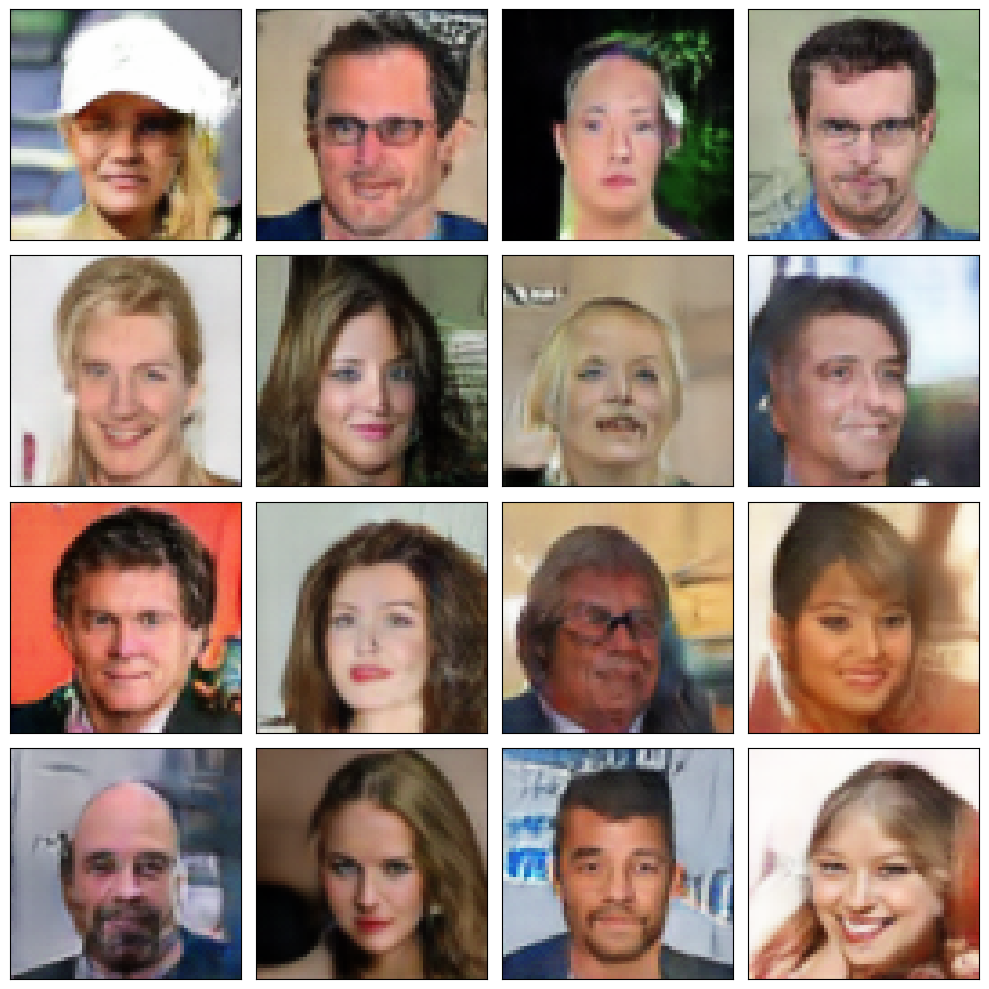

In [15]:
# Optional: Generate and visualize samples without training
@torch.no_grad()
def generate_samples(num_samples=16):
    generator.eval()
    noise = torch.randn(num_samples, latent_dim, device=device)
    fake_images = generator(noise)
    fake_images = (fake_images + 1) / 2.0  # [-1,1] -> [0,1]

    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = fake_images[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
    plt.tight_layout()
    plt.show()
    generator.train()

# Uncomment to generate samples:
generate_samples(16)